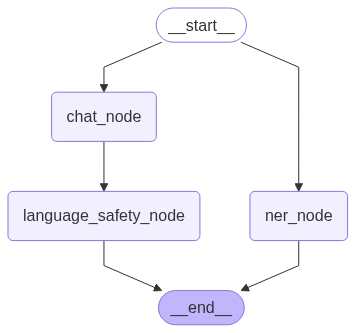

In [1]:
from langgraph.graph import StateGraph, START, END
from langgraph.checkpoint.memory import InMemorySaver
from prompts import doctor_prompt, language_safety_prompt, ner_prompt
from langgraph.graph.message import add_messages
from langchain_core.messages import BaseMessage, SystemMessage, HumanMessage, AIMessage
from langchain_groq import ChatGroq
from typing import TypedDict, Literal, Annotated
from pydantic import Field, BaseModel
from dotenv import load_dotenv
import operator
import json
import sqlite3
from datetime import datetime
import pickle
import base64
import uuid
import os

load_dotenv()

NER_FILE = "ner_data.json"

model = ChatGroq(model="llama-3.1-8b-instant")

class State(TypedDict):
    messages:Annotated[list[BaseMessage], add_messages]
    session_id:str
    time_stamps: Annotated[list[datetime], operator.add]
    ner_entities: Annotated[list[str], operator.add]
    # ner_entities: dict

class PersonEntity(BaseModel):
    """Named person in the client's narrative"""
    name: str = Field(description="Name of the person mentioned")
    relationship: str = Field(description="Relationship to the client (e.g., 'mother', 'ex-partner', 'friend', 'self')")
    significance: str = Field(description="Why this person is significant in the therapeutic context", default="")
    emotional_charge: Literal["positive", "negative", "neutral"] = Field(description="Emotional association the client has with this person", default="neutral")

class PlaceEntity(BaseModel):
    """Named place in the client's narrative"""
    location: str = Field(description="Name or description of the place")
    context: str = Field(description="Context in which this place was mentioned")
    emotional_association: str = Field(description="Emotional significance of this place to the client")

class EventEntity(BaseModel):
    """Significant event in the client's narrative"""
    event: str = Field(description="Description of the event")
    timeframe: str = Field(description="When this event occurred (e.g., 'childhood', 'last year', 'recently')")
    trauma_relevance: Literal["high", "medium", "low"] = Field(description="How relevant this event is to trauma processing")
    description: str = Field(description="Additional therapeutic context about this event")

class SubstanceEntity(BaseModel):
    """Substance use mentioned by client"""
    substance: str = Field(description="Type of substance (alcohol, drugs, medication, etc.)")
    usage_pattern: str = Field(description="How the substance is being used")
    context: str = Field(description="Context around substance use - coping mechanism, medical, social, etc.")

class NamedEntity(BaseModel):
    people: list[PersonEntity] = Field(default_factory=list, description="People mentioned by the client")
    places: list[PlaceEntity] = Field(default_factory=list, description="Places mentioned by the client")
    events: list[EventEntity] = Field(default_factory=list, description="Significant events mentioned by the client")
    substances: list[SubstanceEntity] = Field(default_factory=list, description="Substances mentioned by the client")

#functions to handle json file

def load_ner_file():
    if os.path.exists(NER_FILE):
        with open(NER_FILE, "r", encoding="utf-8") as f:
            return json.load(f)
    return {"people": [], "places": [], "events": [], "substances": []}

def save_ner_file(data):
    with open(NER_FILE, "w", encoding="utf-8") as f:
        json.dump(data, f, indent=4, ensure_ascii=False)

# function to handle nodes

def ner_node(state: State):
    """Extract NER entities with structured output"""
    msg=state['messages'][-1].content
    structured_model = model.with_structured_output(NamedEntity)

    msg_prompt = f"""Extract all named entities from this Message: {msg}"""
    
    ner_result = structured_model.invoke([SystemMessage(content=ner_prompt),
        HumanMessage(content=msg_prompt)
    ])
    
    return {
        "ner_entities": [ner_result]
    }

def chat_node(state: State):
    """A therapeutic chat node"""

    response = model.invoke([SystemMessage(content=doctor_prompt)] + state["messages"])
    return {"messages": [response]}

def language_safety_node(state: State):
    msg_prompt = f"Message: {state['messages'][-1].content}"
    safe_response = model.invoke([SystemMessage(content=language_safety_prompt), HumanMessage(content=msg_prompt)])
    return {"messages": [AIMessage(content=safe_response.content)]}


checkpointer= InMemorySaver()
graph=StateGraph(State)
graph.add_node("chat_node",chat_node)
graph.add_node("ner_node", ner_node)
graph.add_node("language_safety_node", language_safety_node)

graph.add_edge(START,"chat_node")
graph.add_edge(START,"ner_node")
graph.add_edge("chat_node","language_safety_node")
graph.add_edge("ner_node",END)
graph.add_edge("language_safety_node",END)

chatbot=graph.compile(checkpointer=checkpointer)
chatbot

In [2]:
CONFIG={"configurable": {"thread_id": "1"}}

In [4]:
chatbot.invoke({"messages":[HumanMessage(content="How are you doctor")]},config=CONFIG)

{'messages': [HumanMessage(content='Hi I am fayaz', additional_kwargs={}, response_metadata={}, id='16729eb8-149e-4e05-b59c-8b1b940ad961'),
  AIMessage(content="Mm-hmm, Fayaz, nice to meet you. It's great that you've taken this step to work through some challenges. Before we begin, I want to assure you that everything we discuss in this session is completely confidential and safe. What brings you here today, Fayaz? What's been on your mind lately?", additional_kwargs={}, response_metadata={'token_usage': {'completion_tokens': 68, 'prompt_tokens': 1025, 'total_tokens': 1093, 'completion_time': 0.13033468, 'prompt_time': 0.182636805, 'queue_time': 0.002080796, 'total_time': 0.312971485}, 'model_name': 'llama-3.1-8b-instant', 'system_fingerprint': 'fp_2a85b31419', 'service_tier': 'on_demand', 'finish_reason': 'stop', 'logprobs': None}, id='run--8399fb3e-bfa7-4184-aac2-b7d34edeb957-0', usage_metadata={'input_tokens': 1025, 'output_tokens': 68, 'total_tokens': 1093}),
  AIMessage(content="M